In [1]:
import librosa
import librosa.display
import numpy as np
import os
import matplotlib.pyplot as plt
import scipy.io.wavfile
from pydub import AudioSegment

In [2]:
import json

data_root = '/NASdata/AudioData/mandarin/AISHELL-2/iOS/data/wav/'
align = json.load(open('align.json'))

In [3]:
import random

# randomly sample 4 audio files
samples = []
for i in range(4):
    samples.append(random.choice(align[str(i)]))

print(samples)

[['IC0977W0337', 'i1', 2.08, 0.07], ['IC0837W0231', 'ing2', 2.41, 0.11], ['IC0139W0176', 'ou3', 4.82, 0.08], ['IC0555W0251', 'ong4', 1.65, 0.12]]


In [4]:
def chop(audio_path: str, start: float, dur: float):
    extra_sec = (0.8 - dur) / 2
    y, sr = librosa.load(audio_path, sr=16000)
    extra_len = librosa.time_to_samples(extra_sec, sr=sr)
    dur_len = librosa.time_to_samples(dur, sr=sr)

    start, end = librosa.time_to_samples([start - extra_sec, start + dur + extra_sec], sr=sr)
    pad_l = 0
    pad_r = 0
    if start < 0:
        pad_l = -start
        start = 0
    if end > y.size:
        pad_r = end - y.size
        end = y.size
    y = np.pad(y, (pad_l, pad_r), 'constant', constant_values=(0, 0))
    y = y[start:end]

    l = extra_len
    r = extra_len + dur_len
    fade_len = min(extra_len, librosa.time_to_samples(0.025, sr=sr))
    mask = np.zeros_like(y)
    mask[l-fade_len:l] = np.linspace(0, 1, num=fade_len)
    mask[r:r+fade_len] = np.linspace(1, 0, num=fade_len)
    mask[l:r] = 1
    y *= mask
    return y


def specshow(y, sr=16000, ax=plt, fmin=50, fmax=350, cmap='magma'):
    S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=64, n_fft=2048, hop_length=16, fmin=fmin, fmax=fmax)
    librosa.display.specshow(librosa.power_to_db(S, ref=np.max), sr=sr, fmin=fmin, fmax=fmax, cmap=cmap, ax=ax)

# Mel-Spectrogram

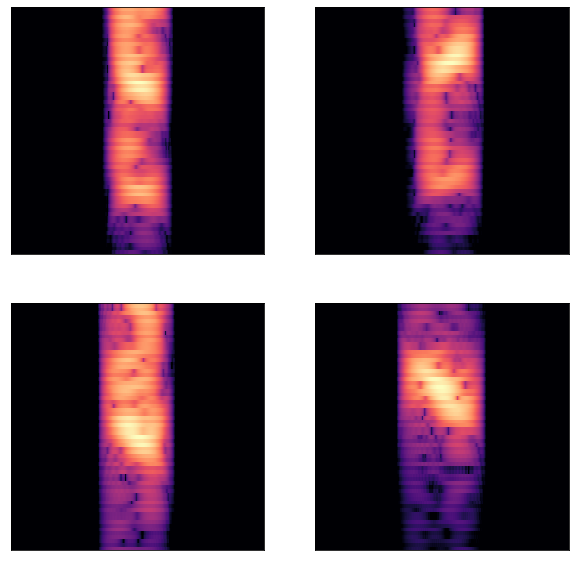

In [5]:
f, axs = plt.subplots(2, 2, figsize=(10, 10))
axs = axs.flatten()

for i in range(4):
    file, phone, start, dur = samples[i]
    spk = file[1:6]

    y = chop(os.path.join(data_root, spk, f'{file}.wav'), start, dur)
    specshow(y, ax=axs[i])

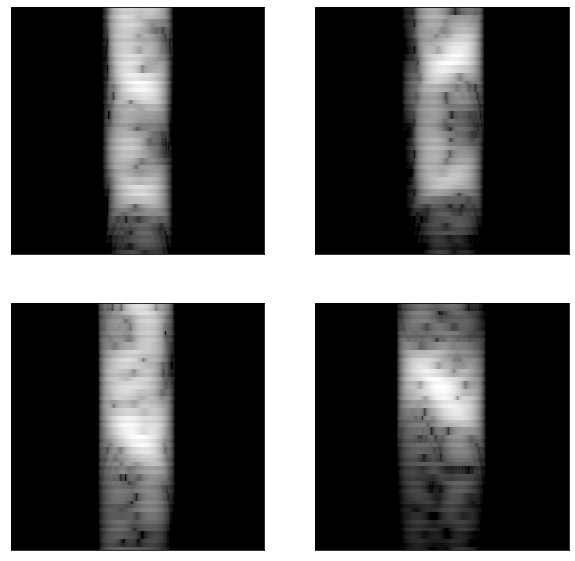

In [6]:
f, axs = plt.subplots(2, 2, figsize=(10, 10))
axs = axs.flatten()
for i in range(4):
    file, phone, start, dur = samples[i]
    spk = file[1:6]

    y = chop(os.path.join(data_root, spk, f'{file}.wav'), start, dur)
    specshow(y, ax=axs[i], cmap='gray')

# Denoise test

In [7]:
# !pip install denoiser

In [10]:
!cp /NASdata/AudioData/mandarin/AISHELL-2/iOS/data/wav/C0139/IC0139W0176.wav denoise_test/input/
!python -m denoiser.enhance --master64 --noisy_dir=denoise_test/input --out_dir=denoise_test/output

/home/tjy/anaconda3/lib/python3.7/site-packages/torchaudio/backend/utils.py:54: UserWarning: "sox" backend is being deprecated. The default backend will be changed to "sox_io" backend in 0.8.0 and "sox" backend will be removed in 0.9.0. Please migrate to "sox_io" backend. Please refer to https://github.com/pytorch/audio/issues/903 for the detail.
  '"sox" backend is being deprecated. '
INFO:denoiser.pretrained:Loading pre-trained real time H=64 model trained on DNS and Valentini.
INFO:__main__:Generate enhanced files | 1/3 | 0.1 it/sec
INFO:__main__:Generate enhanced files | 2/3 | 0.2 it/sec
INFO:__main__:Generate enhanced files | 3/3 | 0.2 it/sec


## Original vs. Denoised

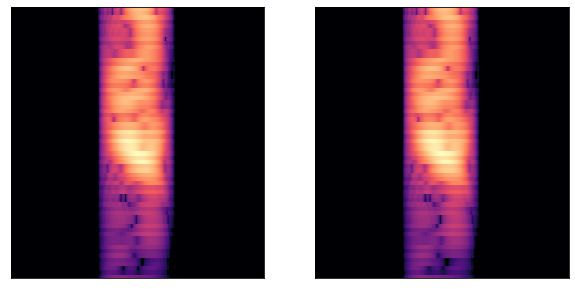

In [12]:
# test file used: ['IC0139W0176', 'ou3', 4.82, 0.08]
f, axs = plt.subplots(1, 2, figsize=(10, 5))
axs = axs.flatten()

start, dur = 4.82, 0.08
y = chop('/NASdata/AudioData/mandarin/AISHELL-2/iOS/data/wav/C0139/IC0139W0176.wav', start, dur)
specshow(y, ax=axs[0], cmap='magma')

y = chop('denoise_test/output/IC0139W0176_enhanced.wav', start, dur)
specshow(y, ax=axs[1], cmap='magma')